# Variance in Sex-Risks

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import feather 

from utils import Utils
from database import Database

u = Utils()
db = Database('Mimir from Munnin')
np.random.seed(u.RANDOM_STATE)

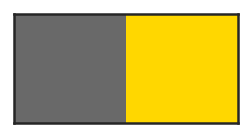

In [2]:
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Arial")
set_style()
custom_palette = ['dimgrey','gold']
sns.set_palette(custom_palette)
sns.palplot(custom_palette)

In [3]:
risks = u.load_df('sex_risks')

## ADR grouped by etiology (SOC)

In [4]:
q = "select descendant_concept_id as hlgt_id, ancestor_concept_id as soc_id from hlgt_name inner join vocab_ancestor  on meddra_concept_id = descendant_concept_id inner join vocab_concept on concept_id = ancestor_concept_id where concept_class_id = 'SOC'"
med_map = pd.DataFrame(db.run(q), columns = ['hlgt_id', 'soc_id'])

soc_name = pd.DataFrame(db.run('select * from soc_name'), columns = ['soc_id', 'soc_name']).set_index('soc_id')

adr_map_soc = []
for idx, data in risks.iterrows(): 
    if data.adr_class == 'soc': 
        adr_map_soc.append(data.adr_name)
    else: 
        x = med_map.query('hlgt_id == @data.adr').get('soc_id').values[0]
        adr_map_soc.append(soc_name.at[x, 'soc_name'])
        
    
risks['adr_map_soc'] = adr_map_soc

Connection opened successfully.


In [5]:
f_count = risks.query('logROR_avg>0').groupby(['adr_map_soc']).count().get(['adr'])
m_count = risks.query('logROR_avg<0').groupby(['adr_map_soc']).count().get(['adr'])
ratio = []
for soc in m_count.index: 
    val = np.log(f_count.loc[soc].adr/m_count.loc[soc].adr)
    ratio.append((val, soc))
    
m_draw = [x2 for (x1,x2) in sorted(ratio)[:3] ]
f_draw = [sorted(ratio)[-5][1], sorted(ratio)[-3][1], sorted(ratio)[-2][1]]

Musculoskeletal and connective tissue disorders


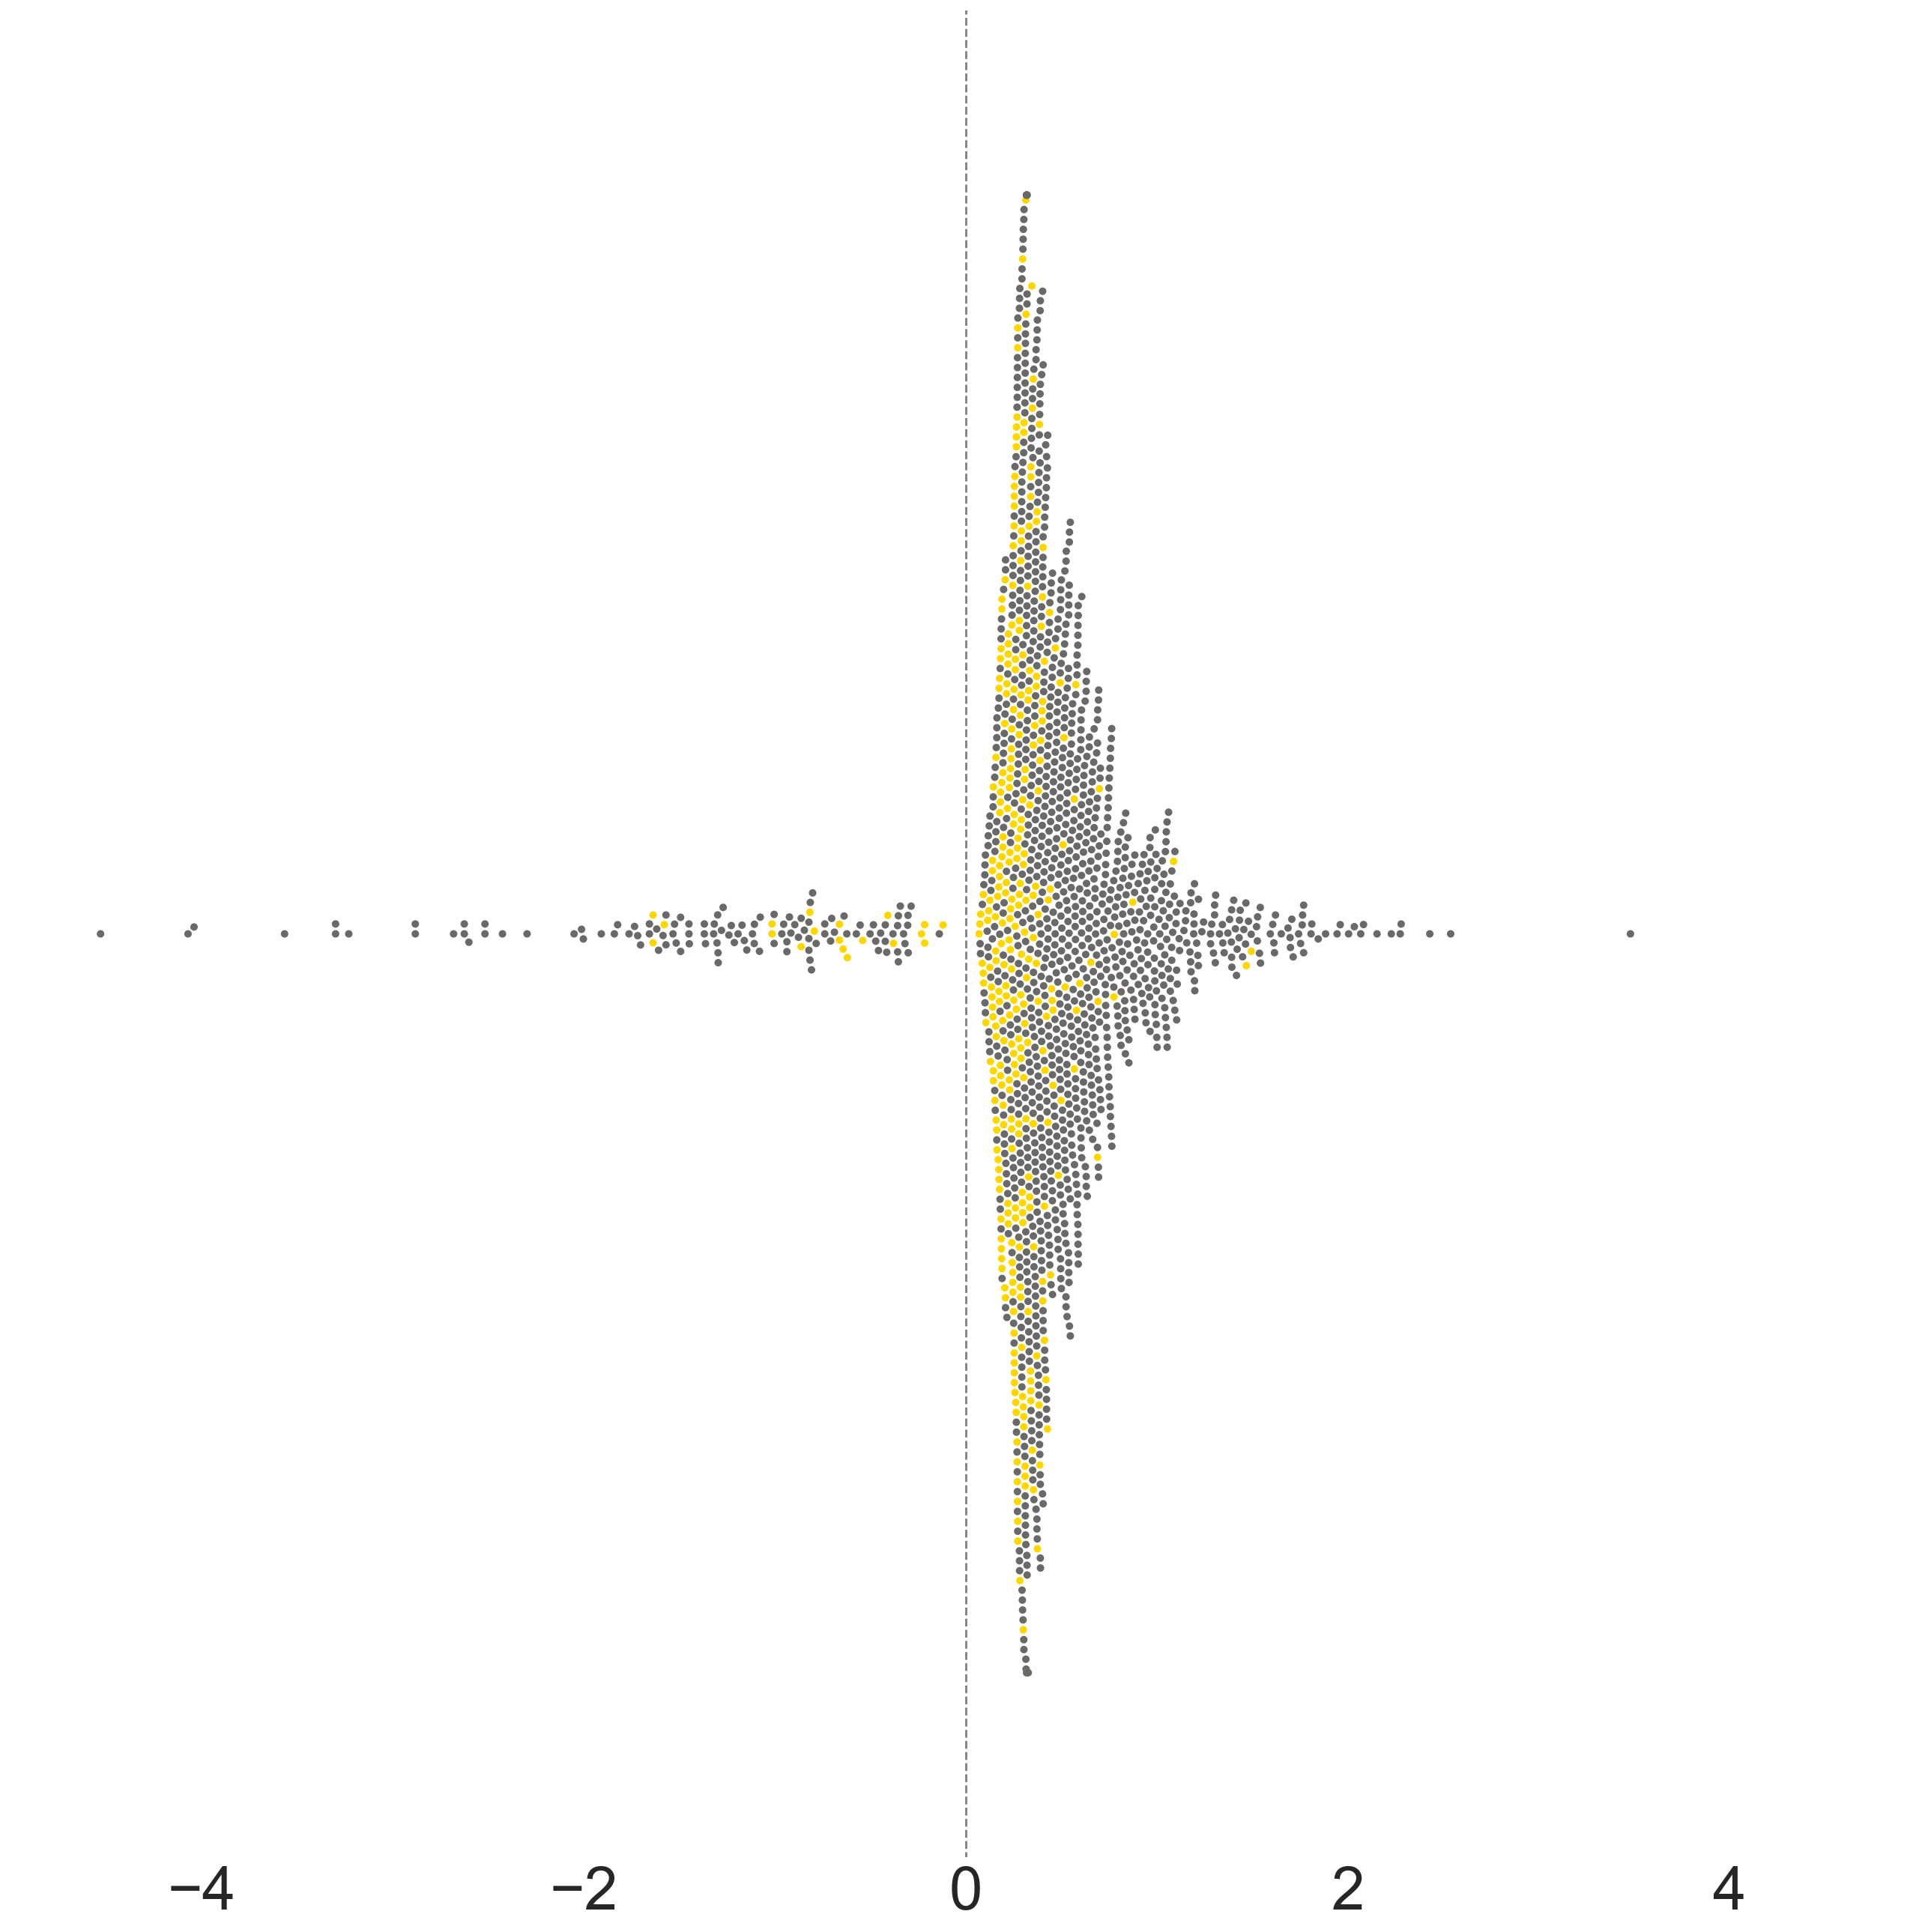

Eye disorders


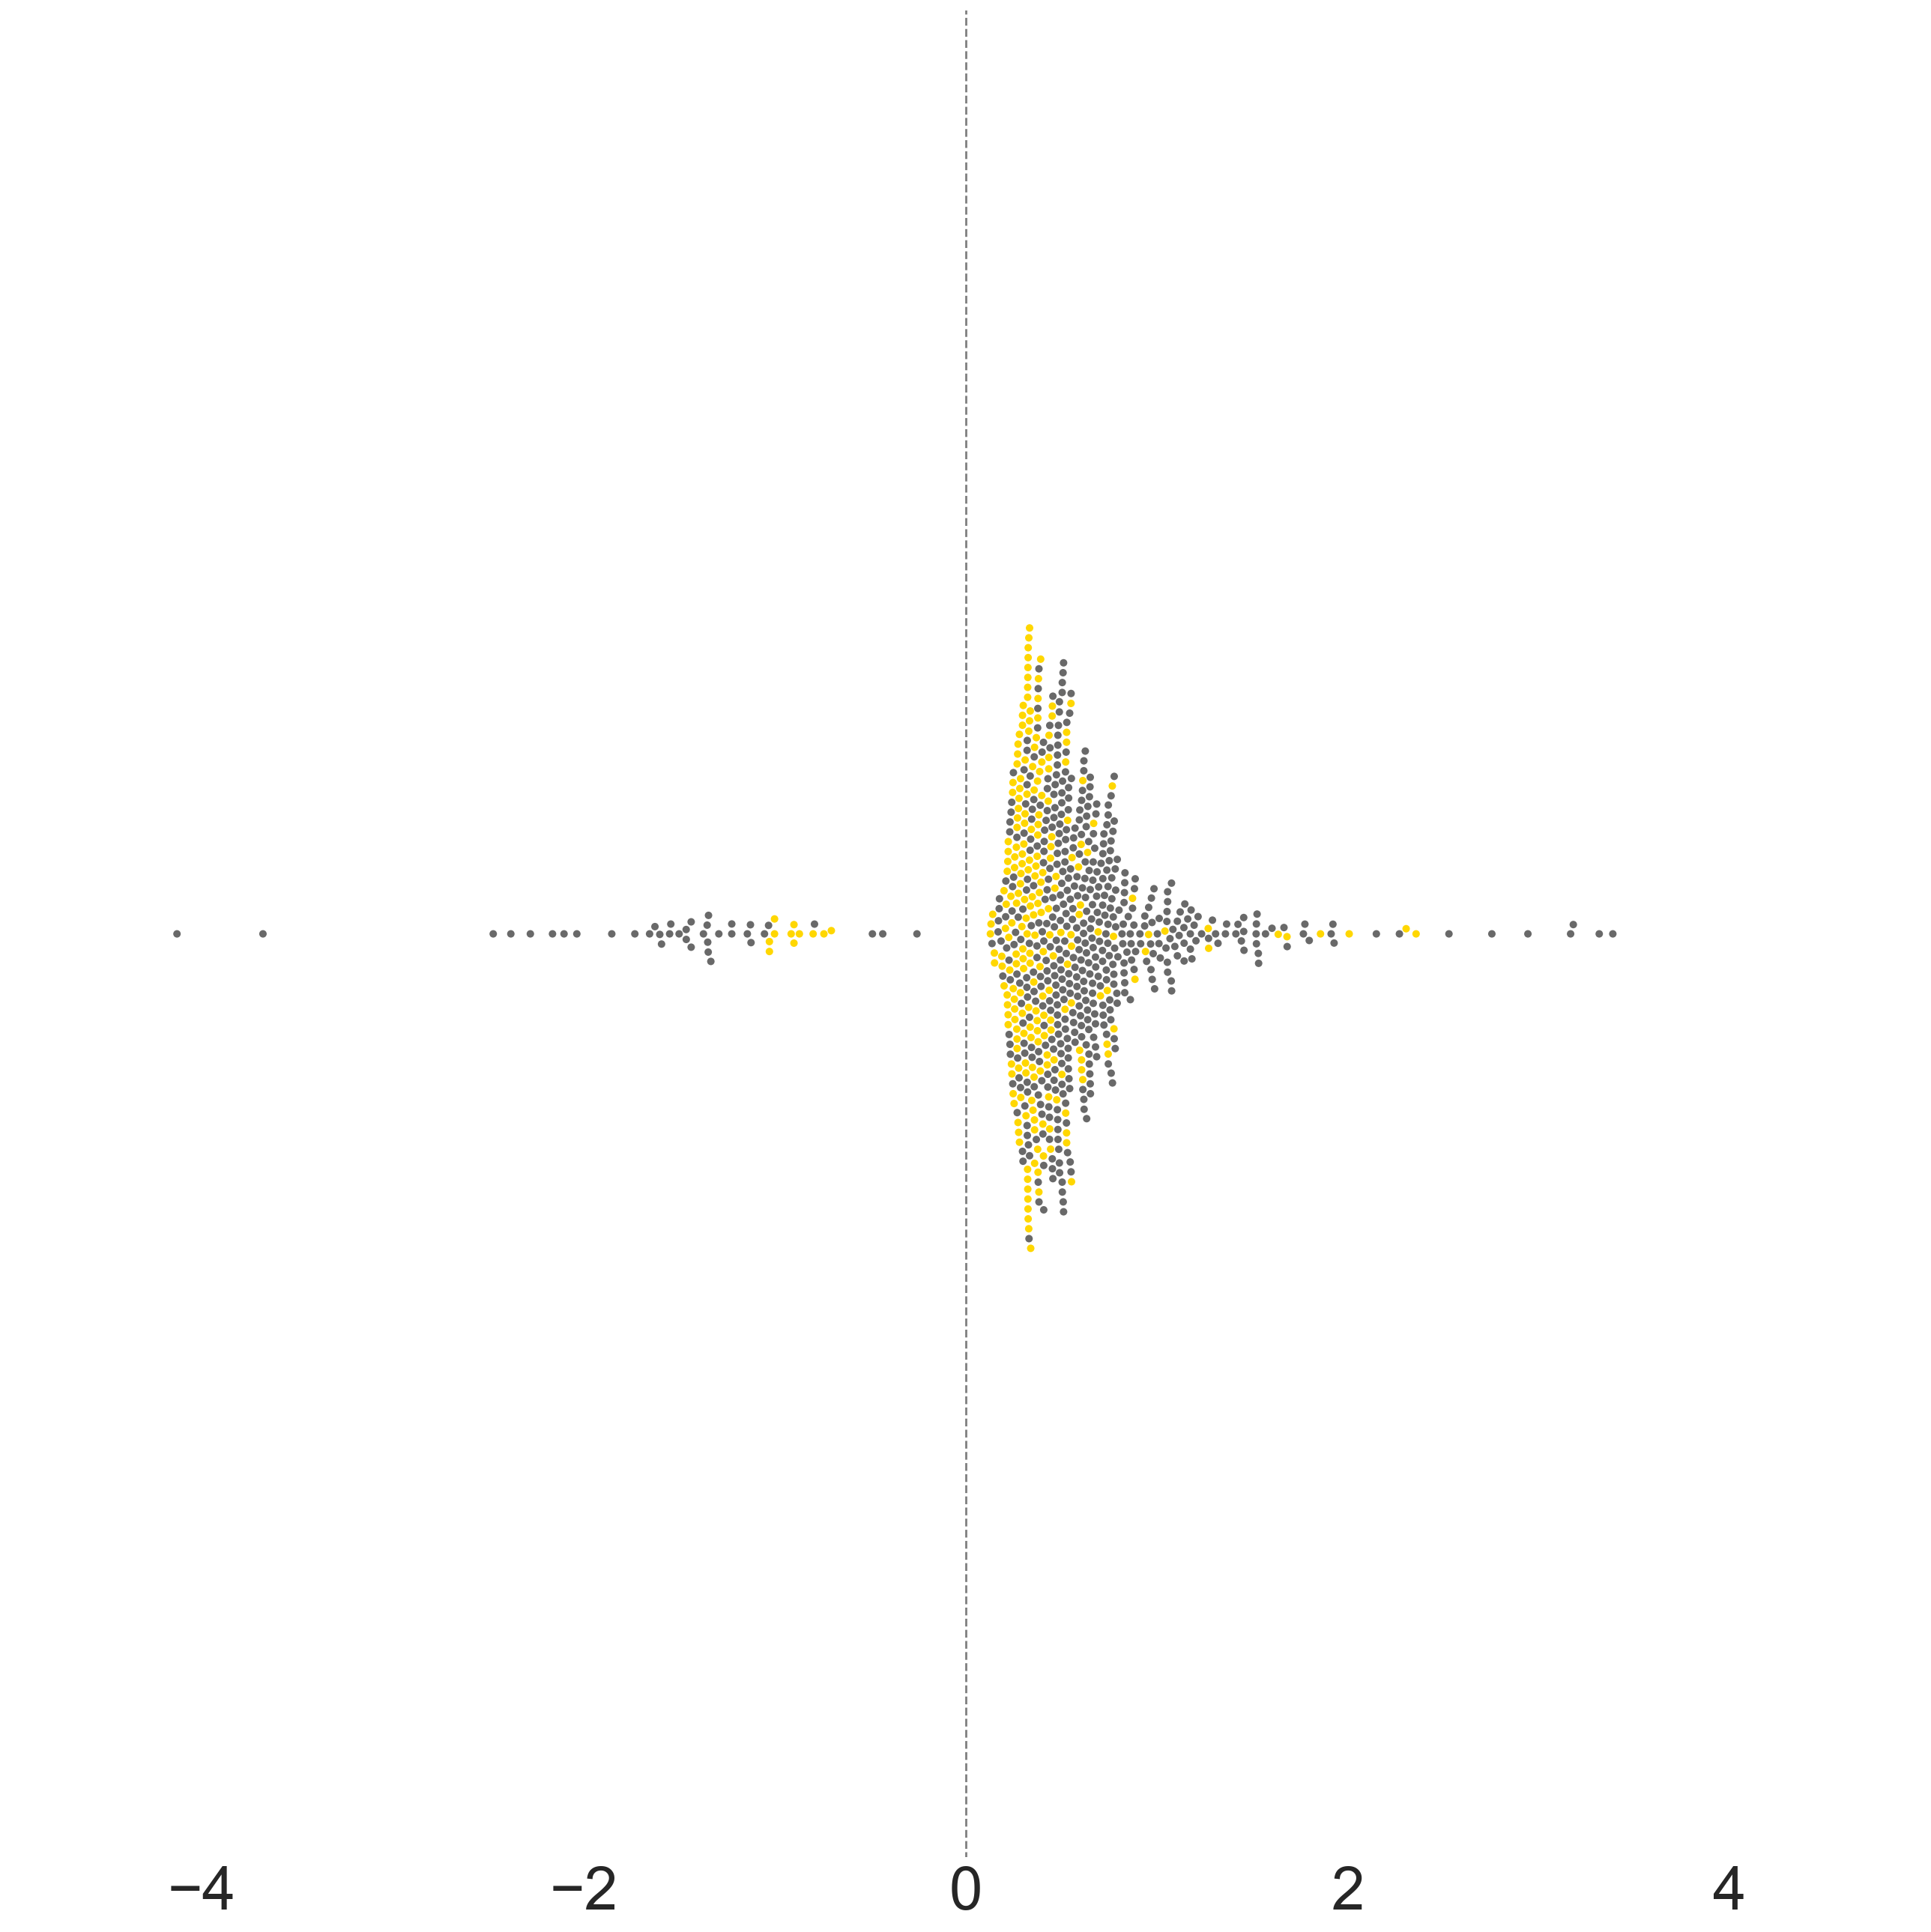

Ear and labyrinth disorders


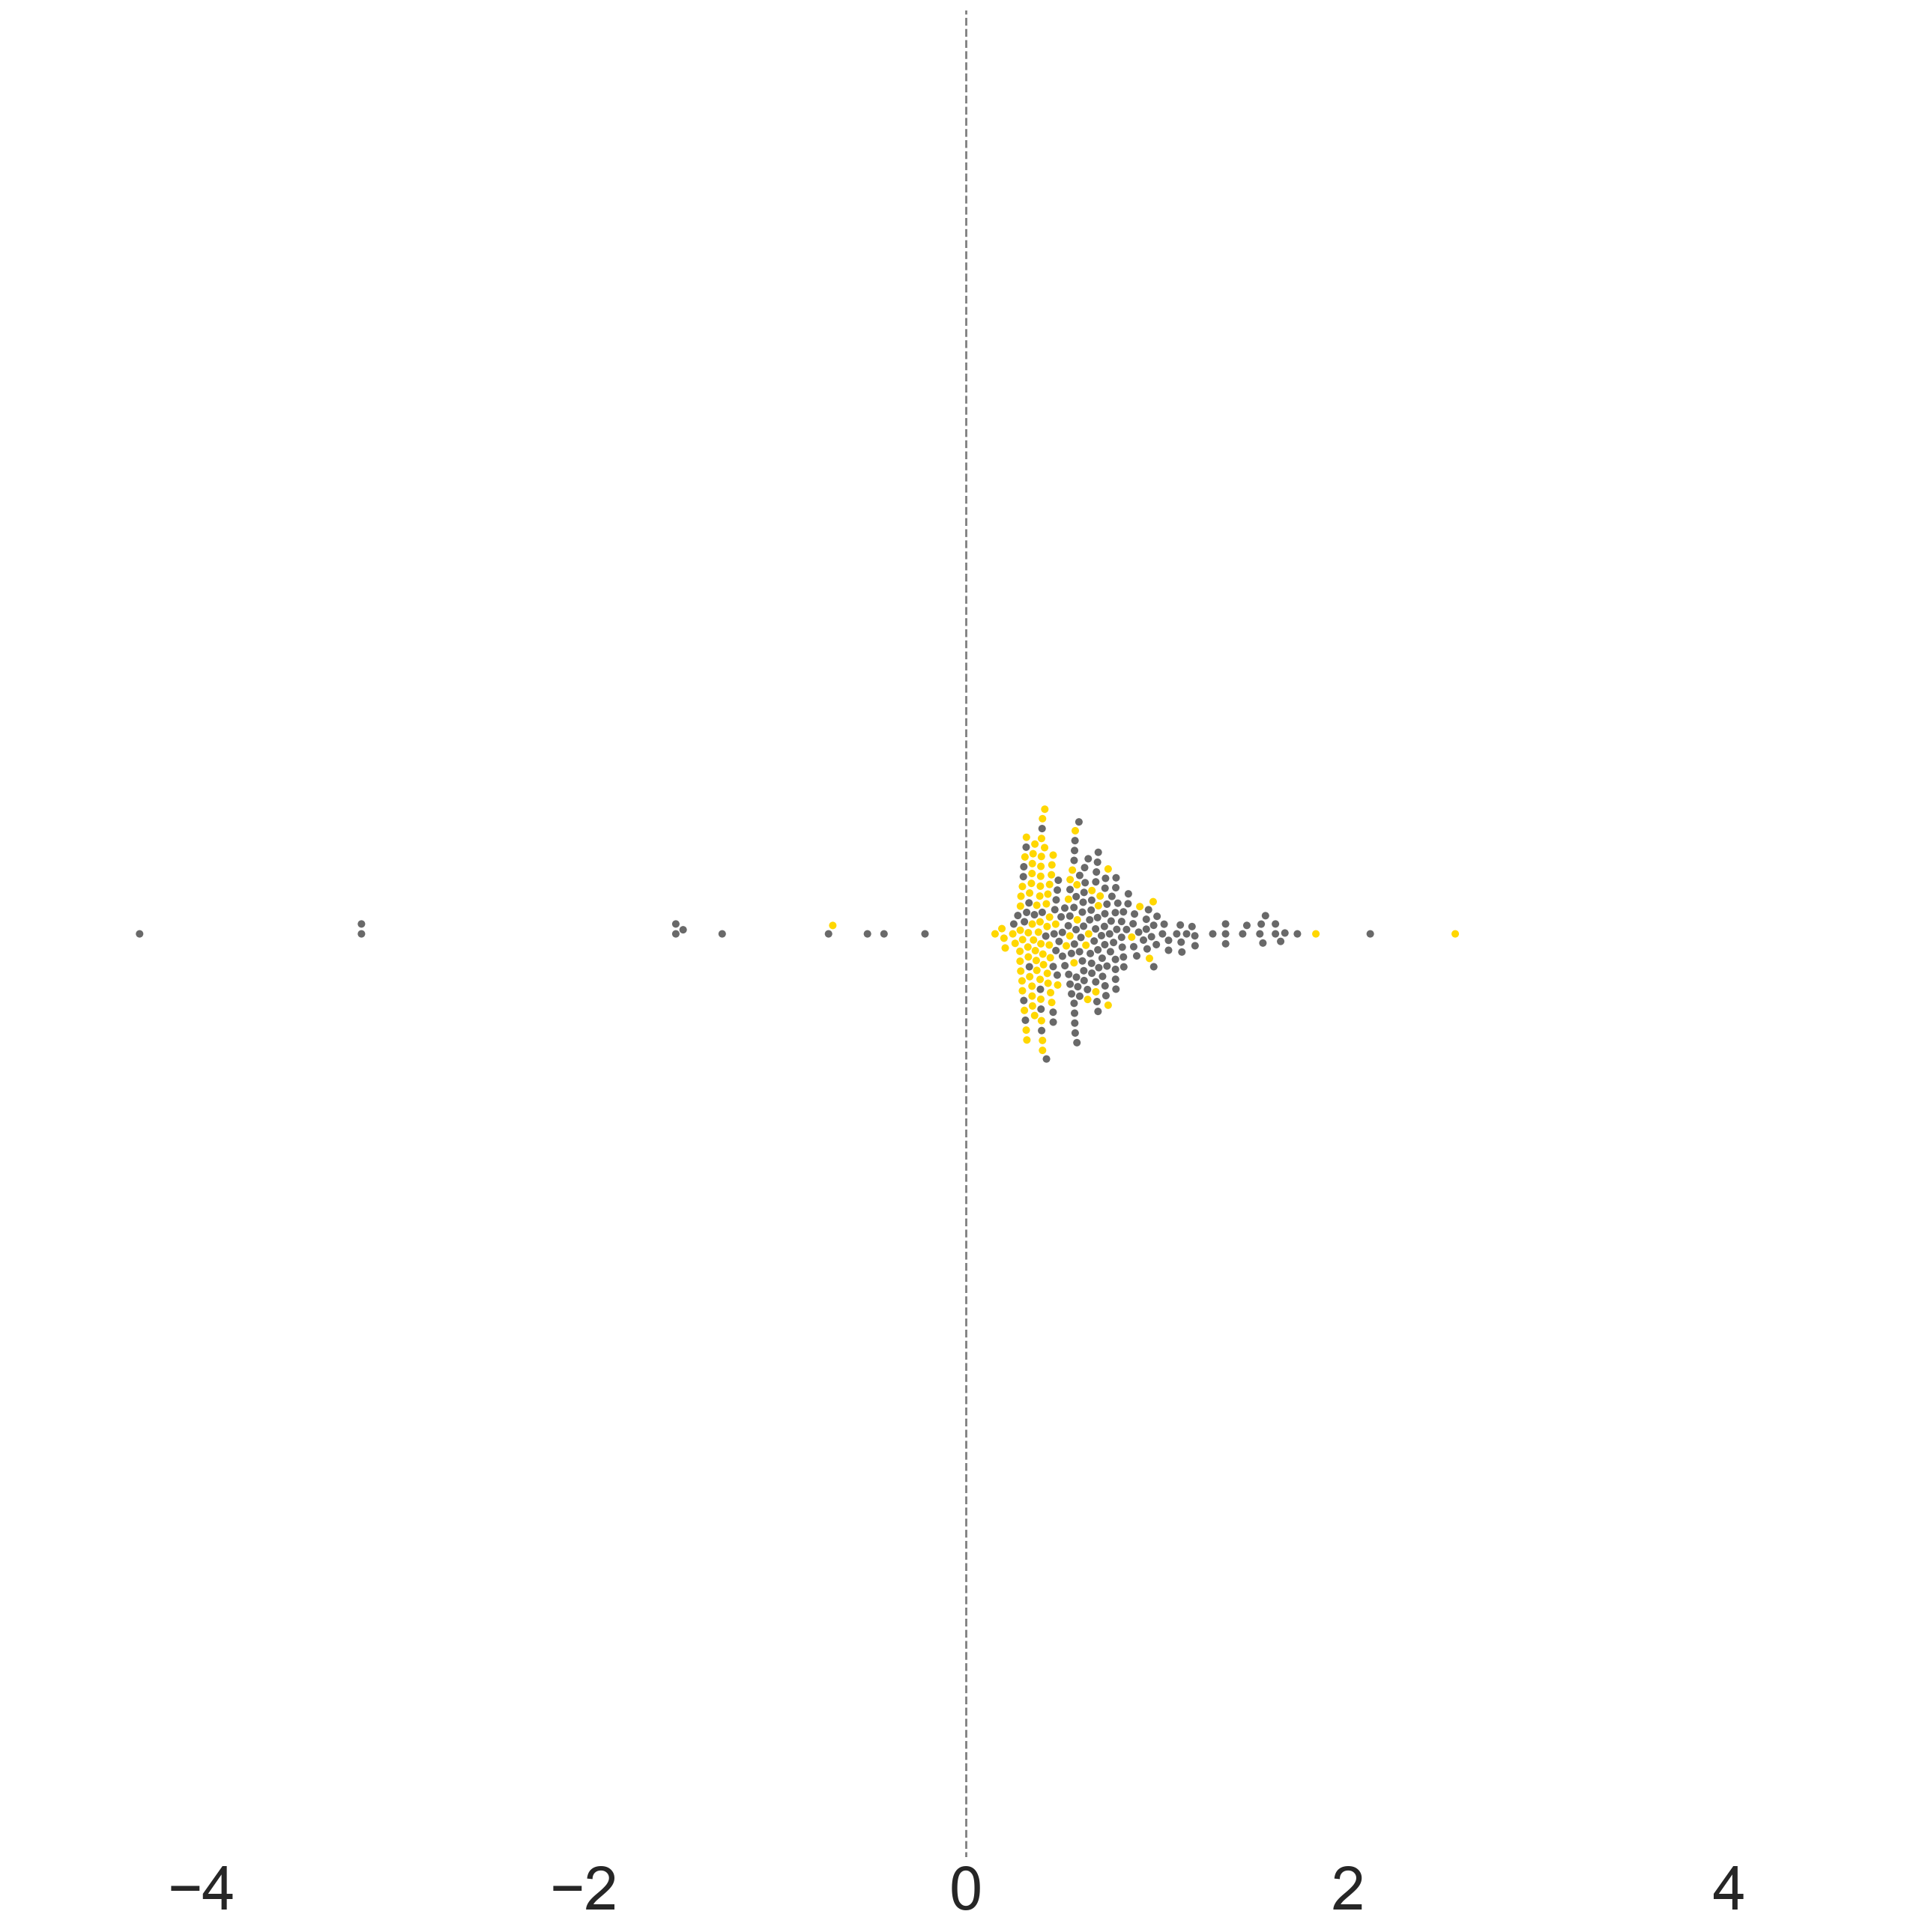

In [6]:
for i in range(3): 

    print(f_draw[i])

    set_style()
    fig, ax = plt.subplots(1, sharex=False, sharey=False, figsize=(18,18))
    ax = fig.get_axes()[0]

    df = risks.query('adr_map_soc ==@f_draw[@i]')
    sns.swarmplot(x='logROR_avg', y='adr_map_soc', hue='adr_class', dodge=False, data=df, ax=ax, hue_order=['hlgt','soc'])

    sns.despine(left=True, bottom=True)
    ax.vlines(0, -10, 10, 'k','dashed', alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim((-5, 5))
    ax.yaxis.set_visible(False)
    ax.tick_params(labelsize=40)
    ax.legend([])
    plt.tight_layout()
    plt.show()

Congenital, familial and genetic disorders


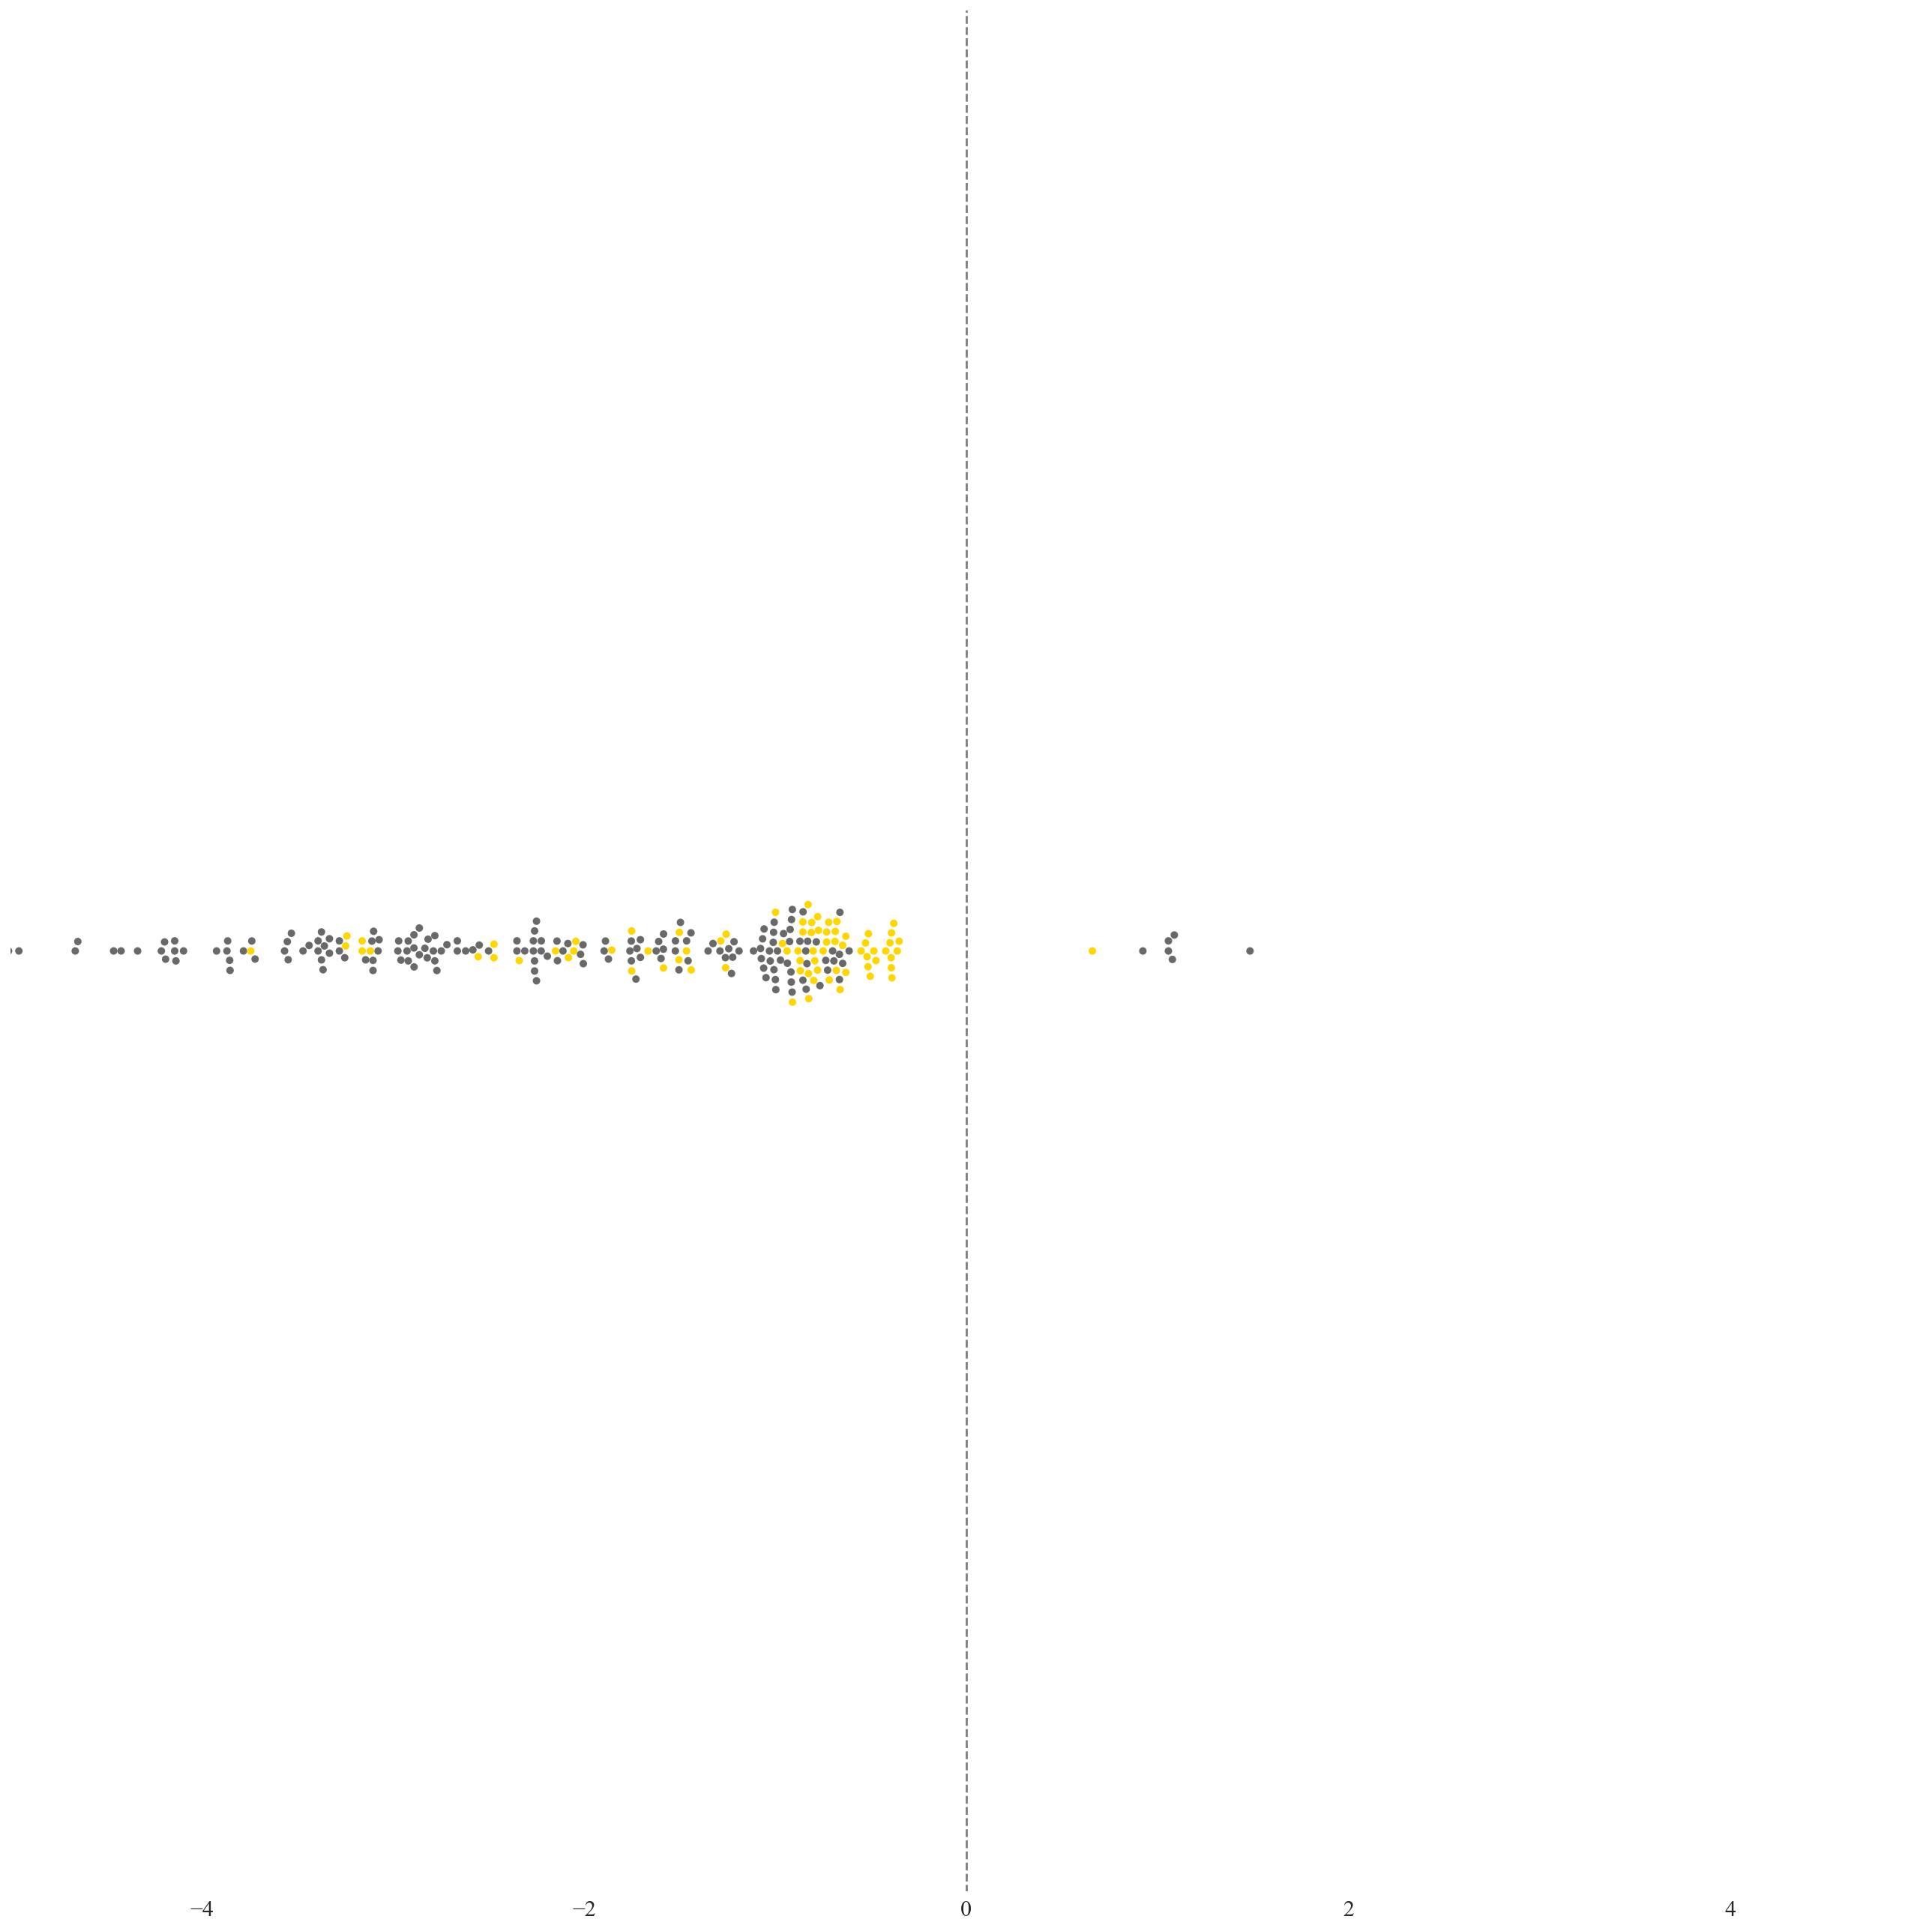

Neoplasms benign, malignant and unspecified (incl cysts and polyps)


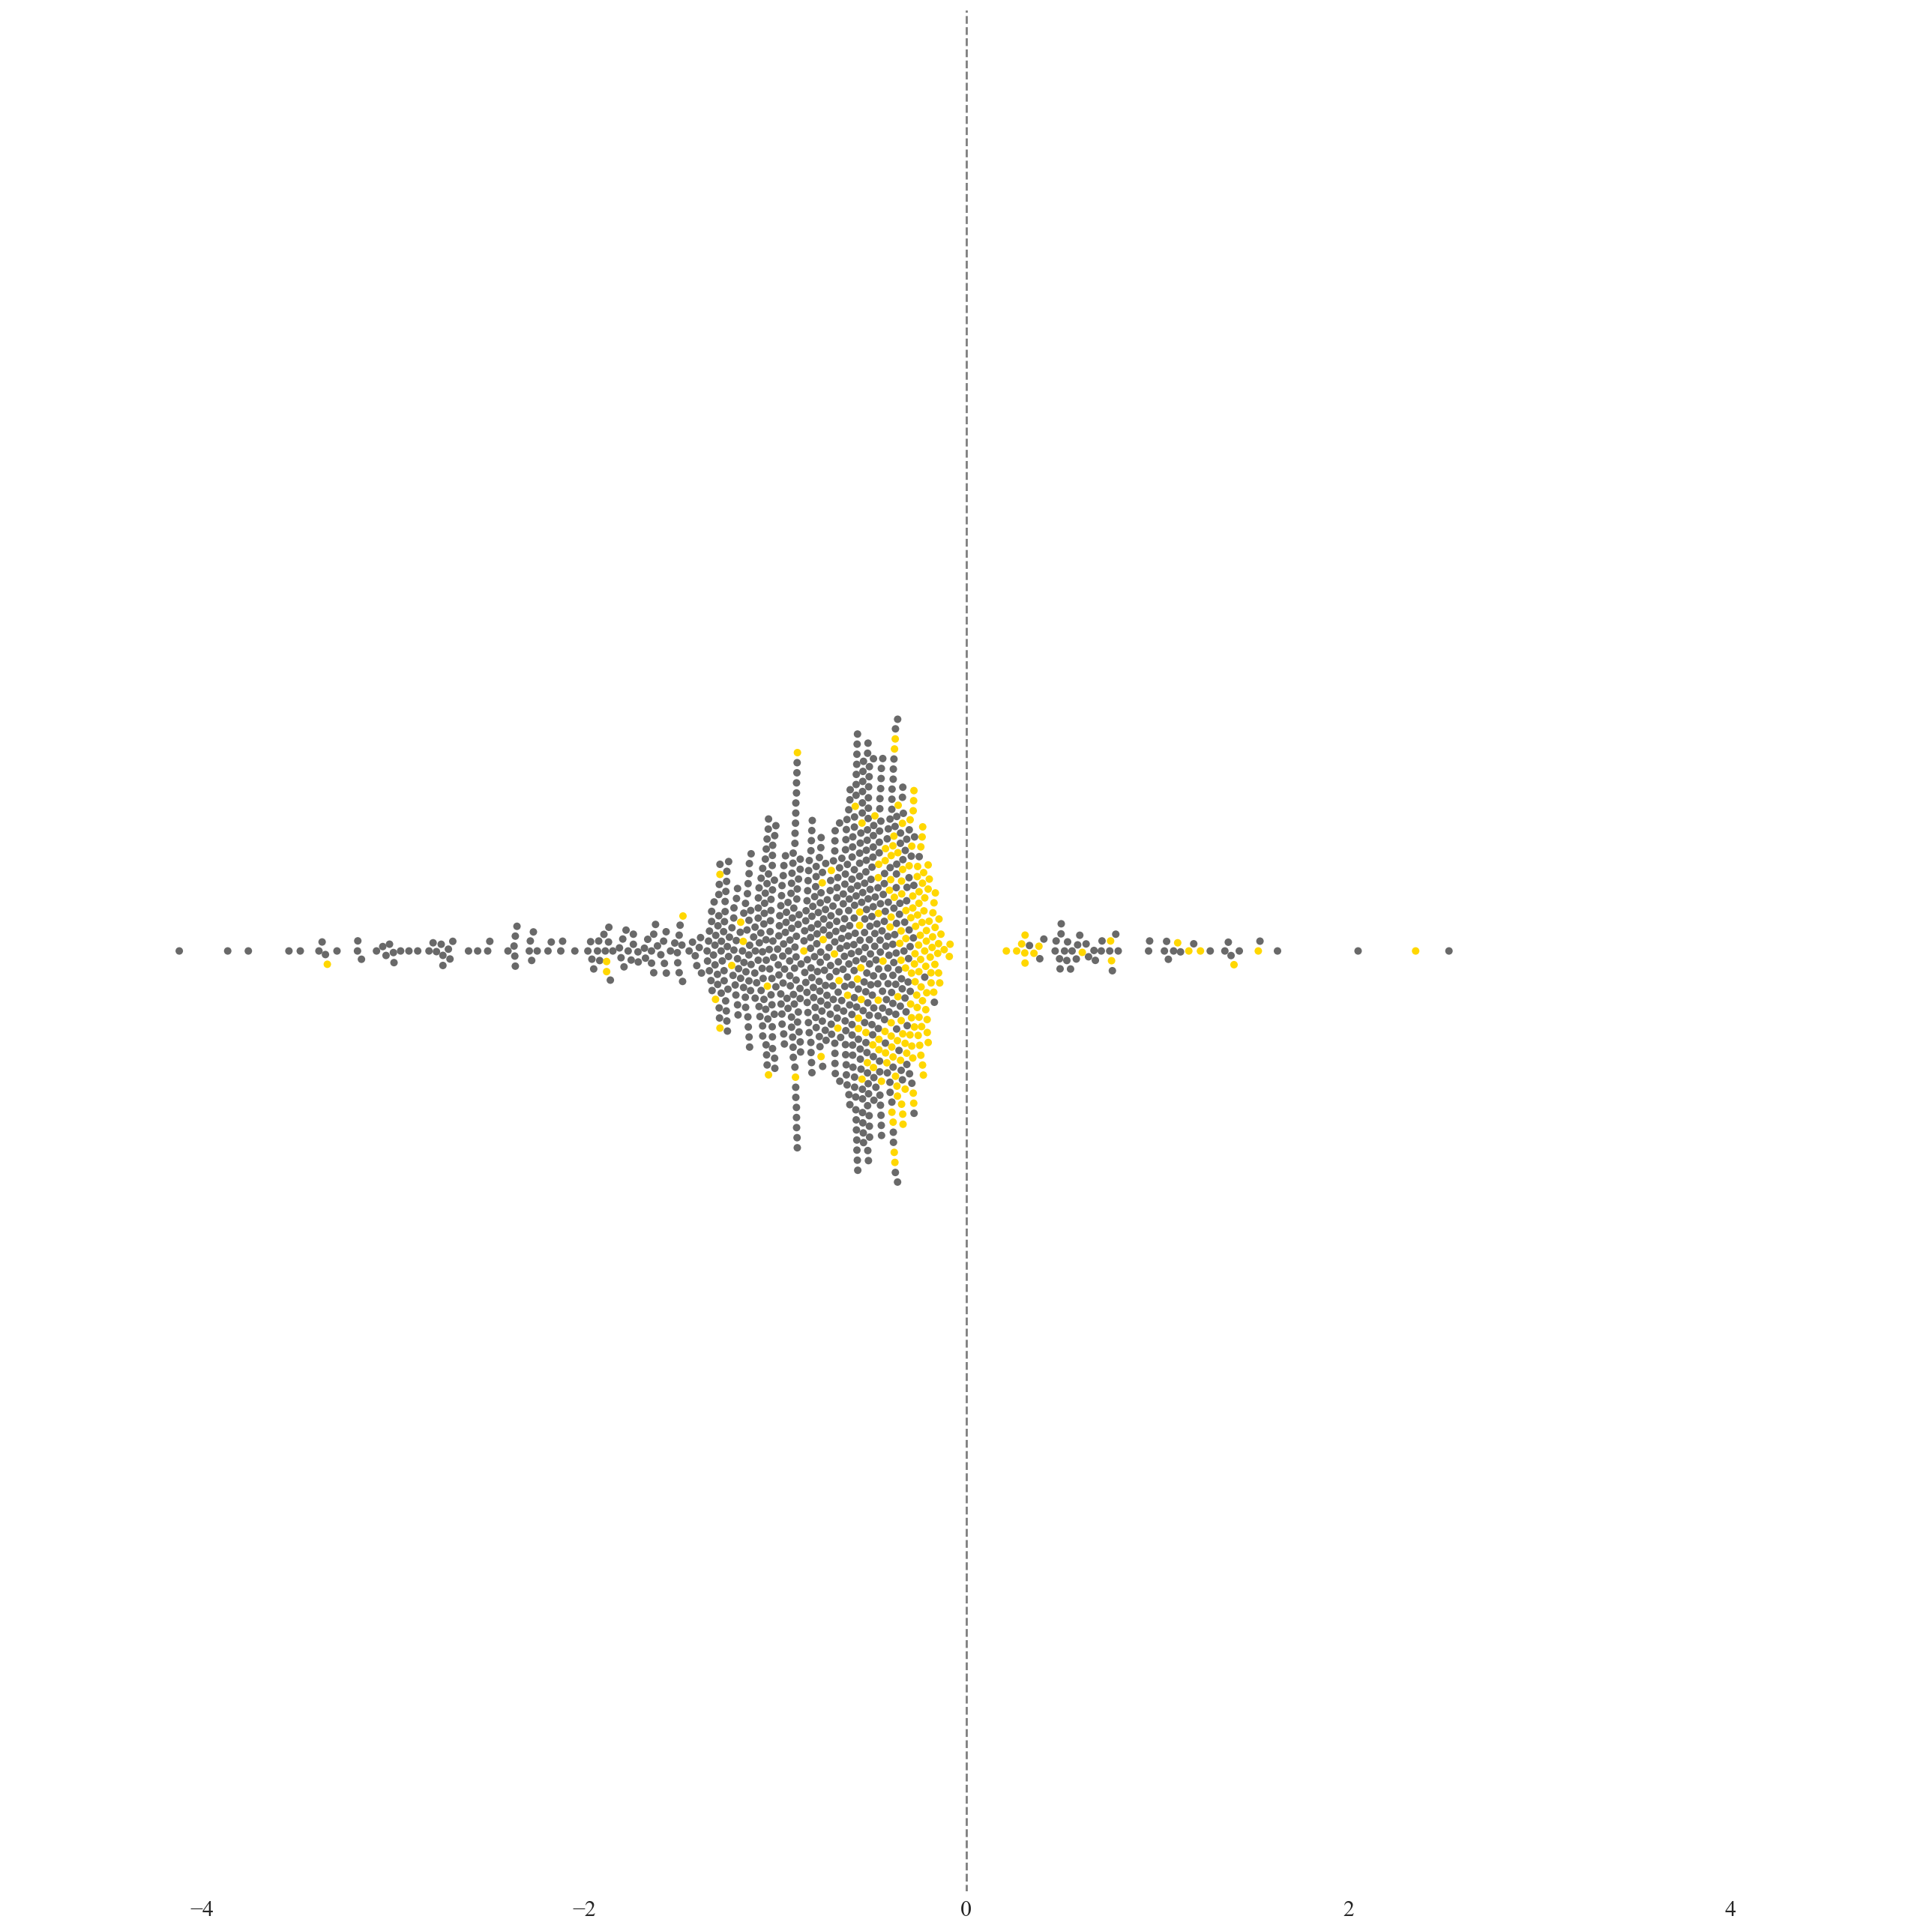

Blood and lymphatic system disorders


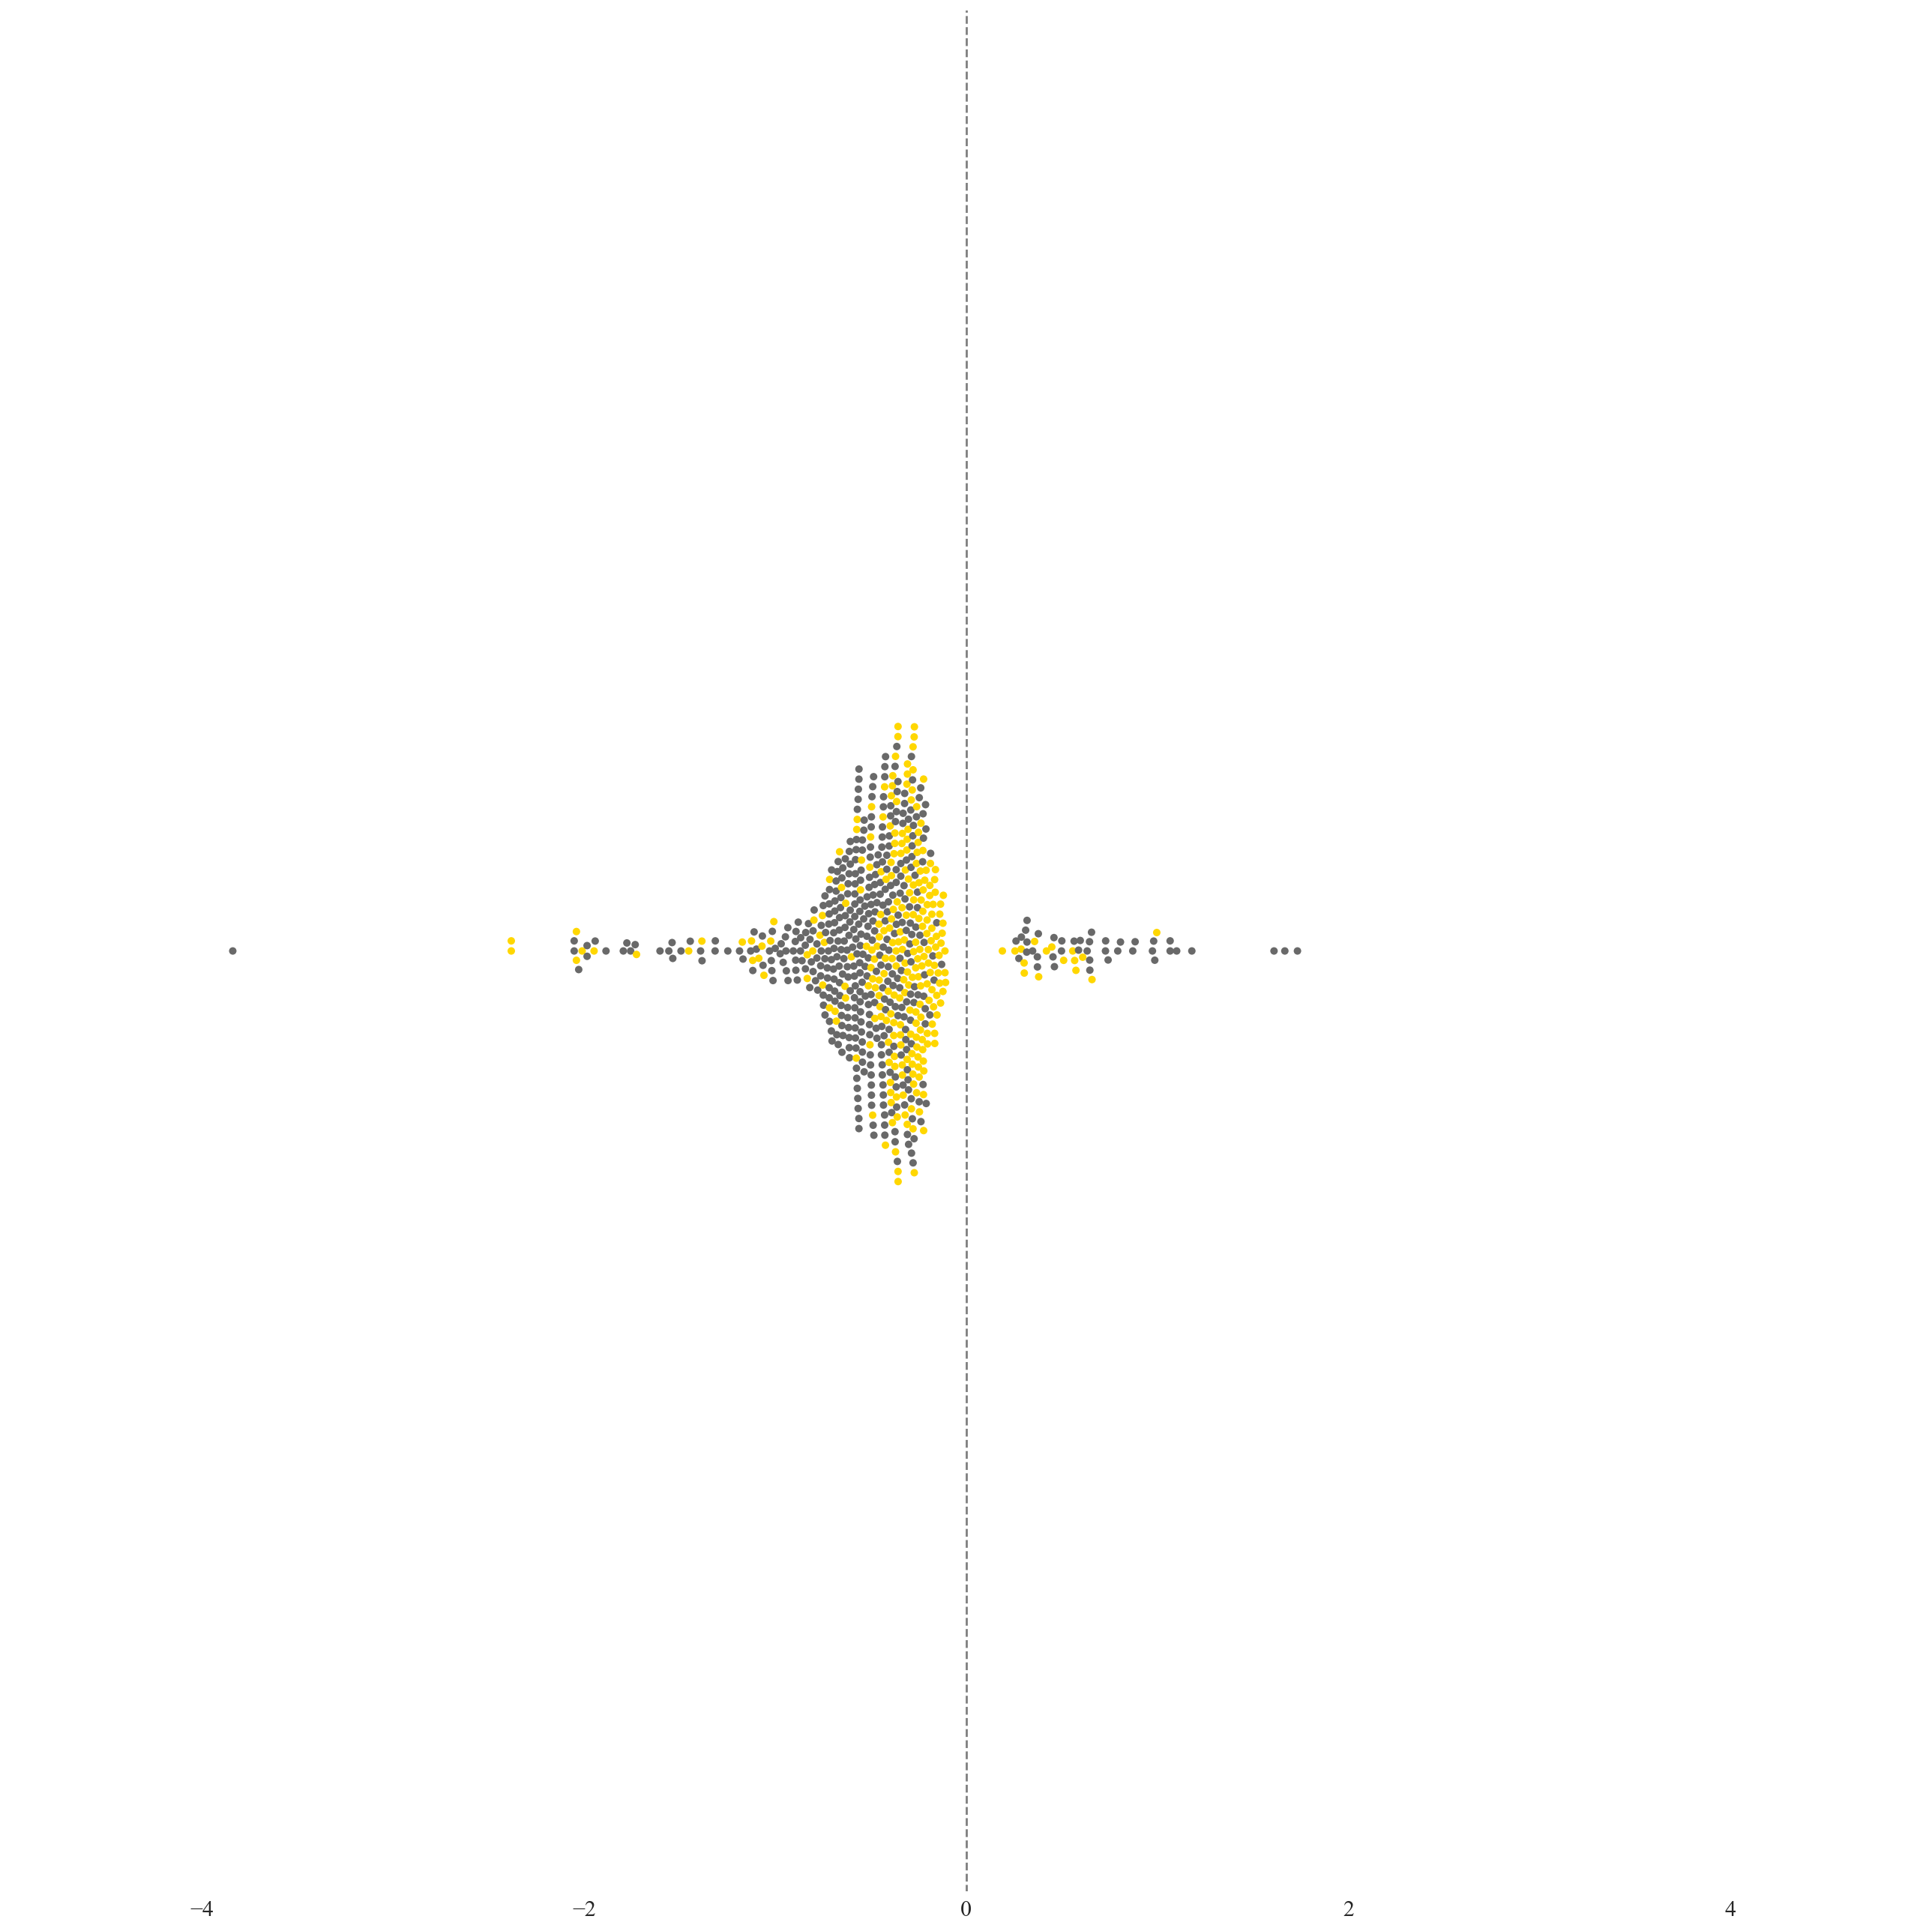

In [66]:
for i in range(3): 

    print(m_draw[i])

    set_style()
    fig, ax = plt.subplots(1, sharex=False, sharey=False, figsize=(18,18))
    ax = fig.get_axes()[0]

    df = risks.query('adr_map_soc ==@m_draw[@i]')
    sns.swarmplot(x='logROR_avg', y='adr_map_soc', hue='adr_class', dodge=False, data=df, ax=ax, hue_order=['hlgt','soc'])

    sns.despine(left=True, bottom=True)
    ax.vlines(0, -10, 10, 'k','dashed', alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim((-5, 5))
    ax.yaxis.set_visible(False)
    ax.tick_params(labelsize=15)
    ax.legend([])#['HLGT', 'SOC'], title='', fontsize=20)
    plt.tight_layout()
    plt.show()

## Drugs grouped by mechanism (ATC 4)

In [60]:
atc_map = pd.DataFrame(db.run('select * from atc_4_atc_5'), columns = ['atc_4_id', 'atc_5_id'])

atc4_name = pd.DataFrame(db.run('select * from atc_4_name'), columns = ['atc_id', 'atc_name']).set_index('atc_id')

drug_map_soc = []
for idx, data in risks.iterrows(): 
    if data.drug_class == 4: 
        drug_map_soc.append(data.drug_name)
    else: 
        if atc_map.query('atc_5_id == @data.drug').empty: 
            drug_map_soc.append('Unk')
        else: 
            x = atc_map.query('atc_5_id == @data.drug').get('atc_4_id').values[0]
            drug_map_soc.append(atc4_name.at[x, 'atc_name'])
        
    
risks['drug_map_soc'] = drug_map_soc

In [61]:
f_count = risks.query('logROR_avg>0').groupby(['drug_map_soc']).count().get(['adr'])
m_count = risks.query('logROR_avg<0').groupby(['drug_map_soc']).count().get(['adr'])
ratio = []
for name in m_count.index: 
    if name in f_count.index and name in m_count.index:
        val = np.log(f_count.loc[name].adr/m_count.loc[name].adr)
        ratio.append((val, name))
    

In [ ]:
names = [name for _,name in sorted(ratio)[-25:]]

In [62]:
names = ['Calcineurin inhibitors','Taxanes','Pyrimidine derivatives','Digitalis glycosides','Alpha and beta blocking agents','Insulins and analogues for injection, fast-acting']

Calcineurin inhibitors


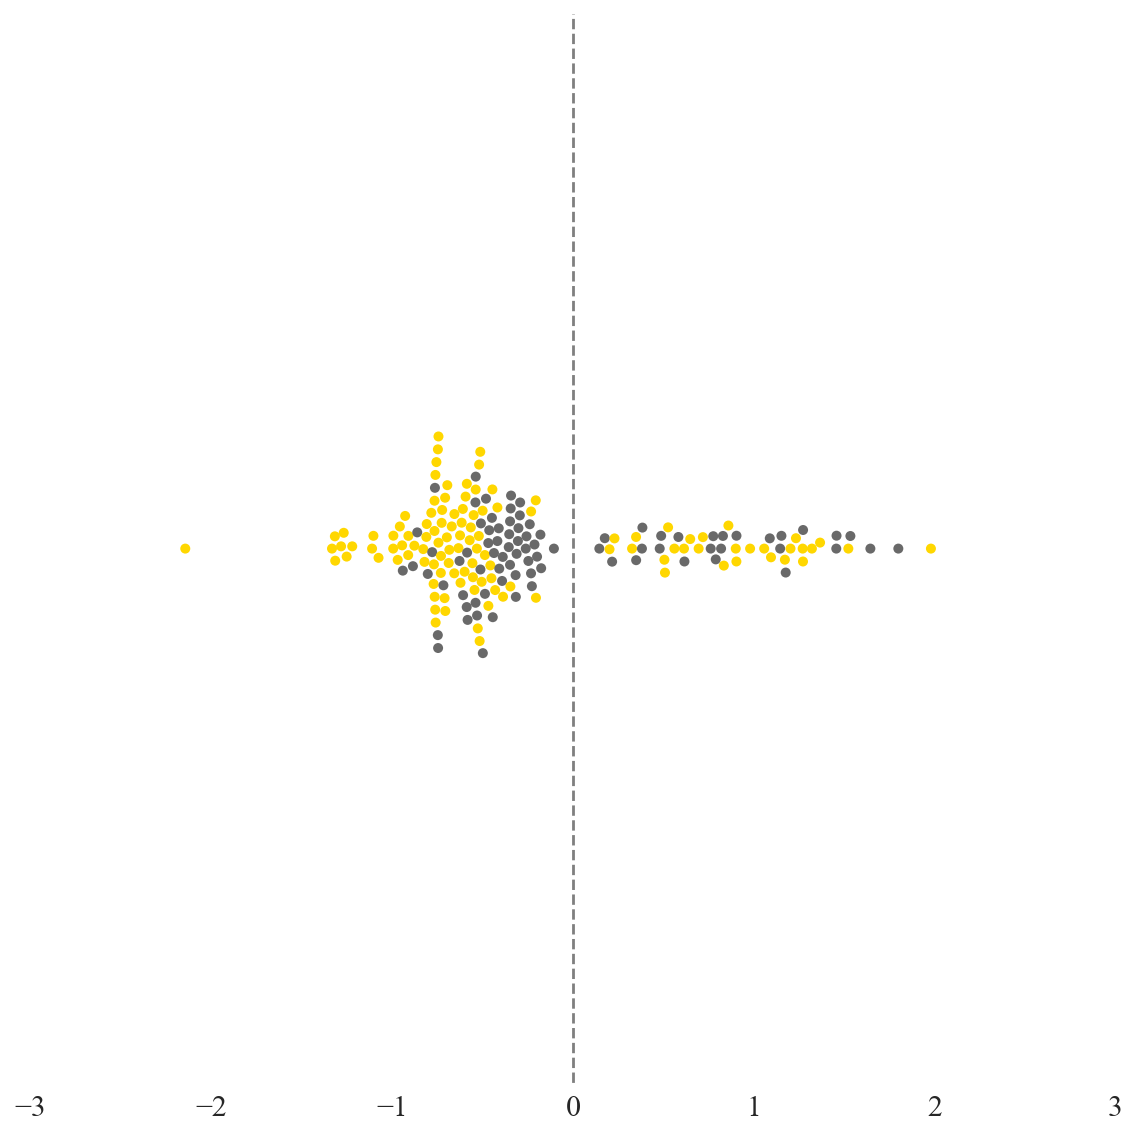

Taxanes


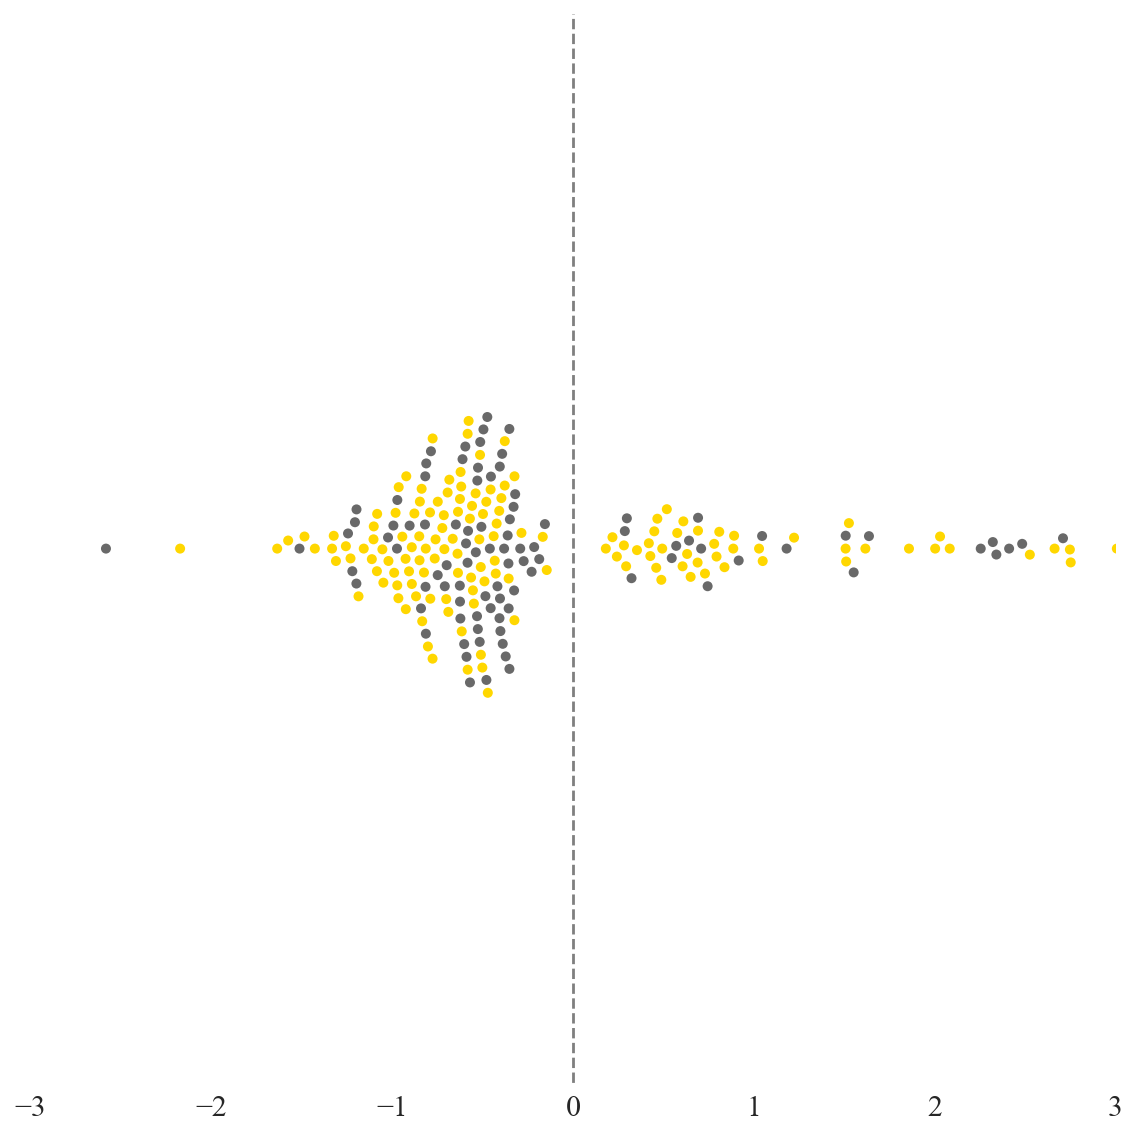

Pyrimidine derivatives


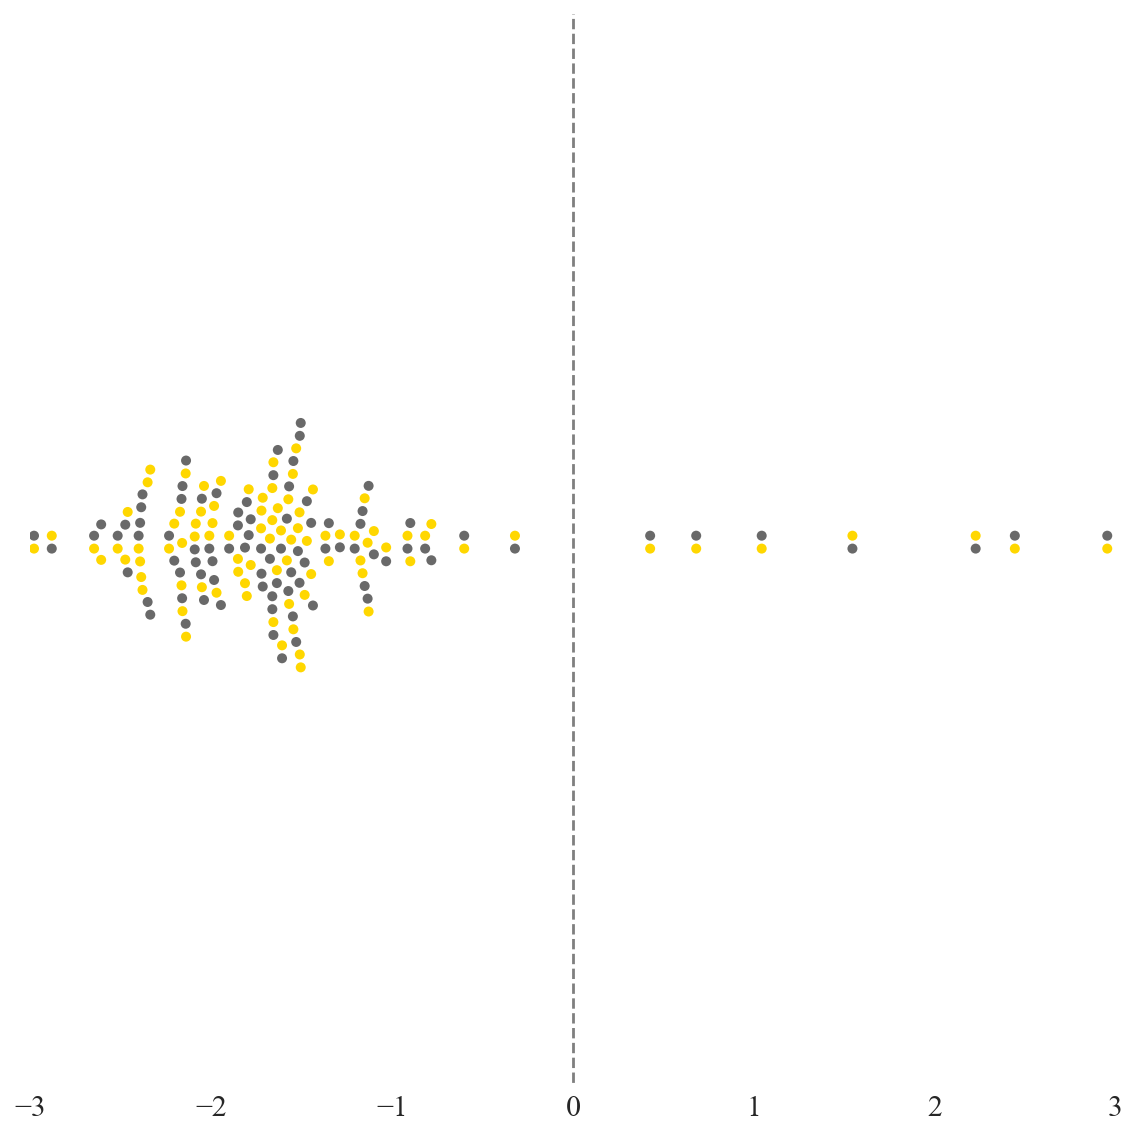

Digitalis glycosides


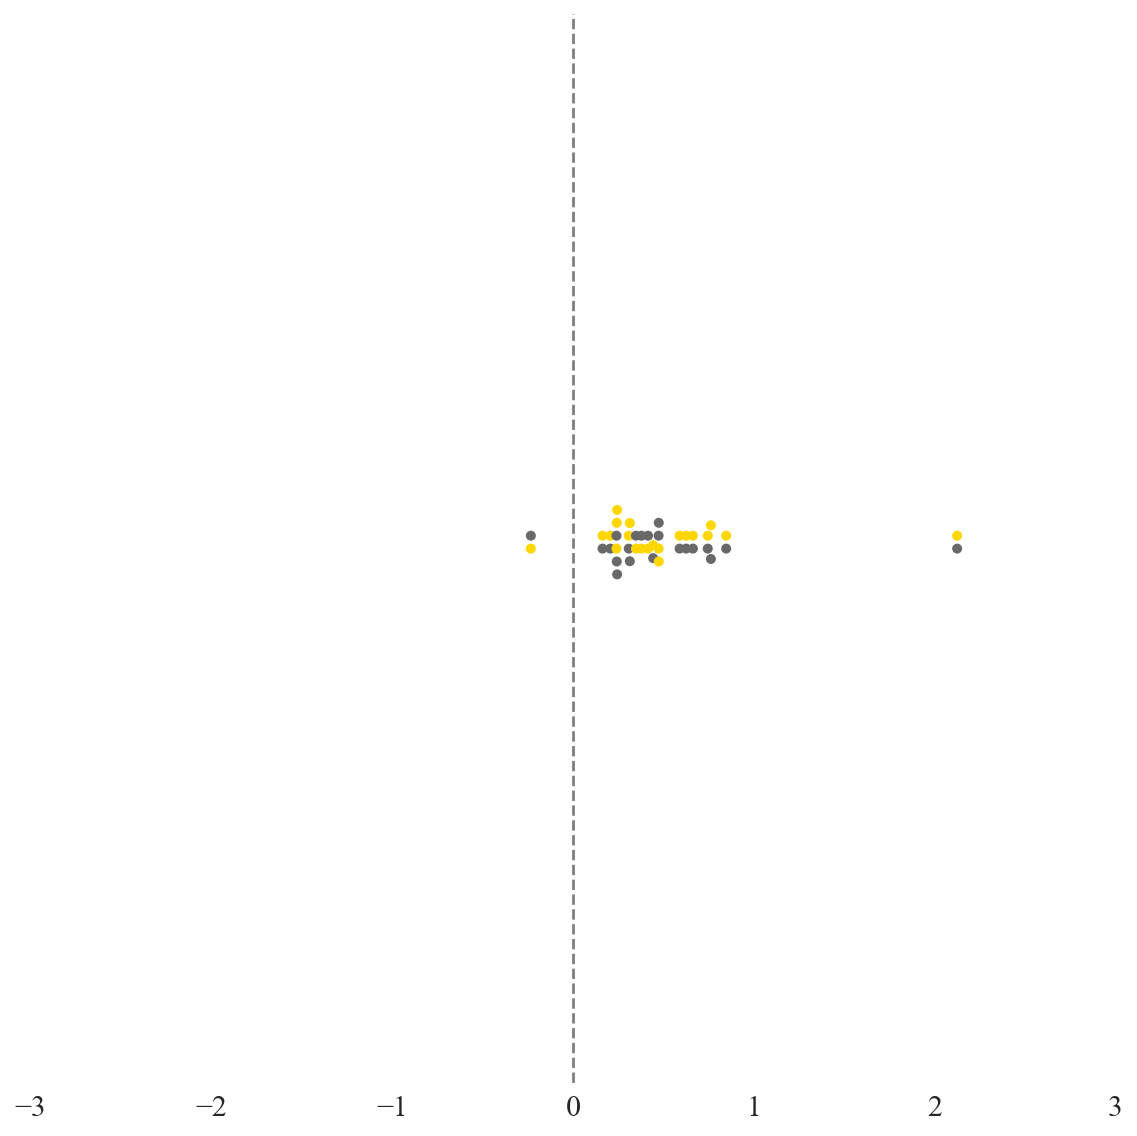

Alpha and beta blocking agents


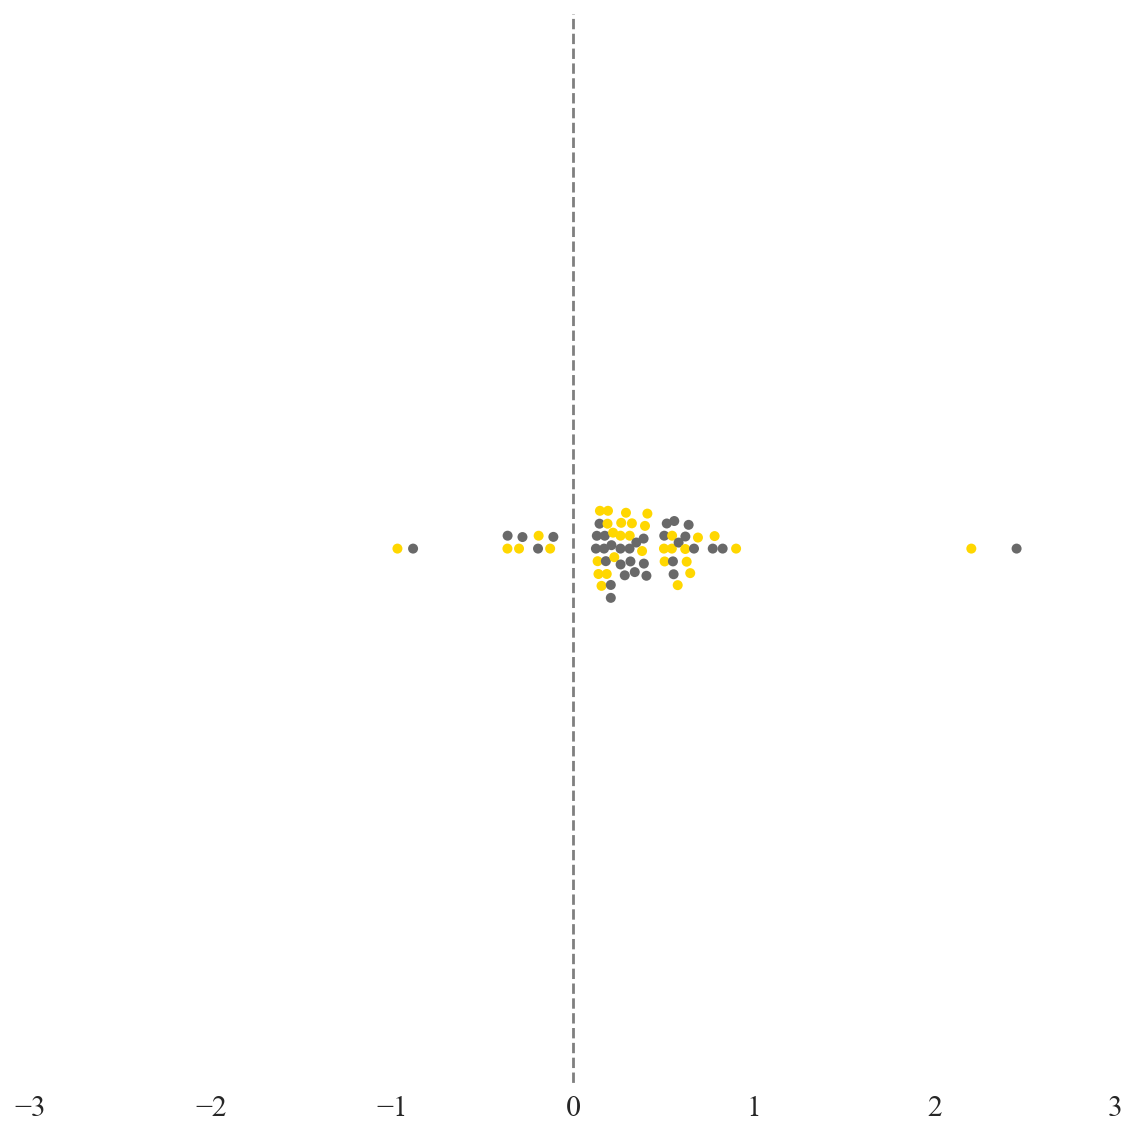

Insulins and analogues for injection, fast-acting


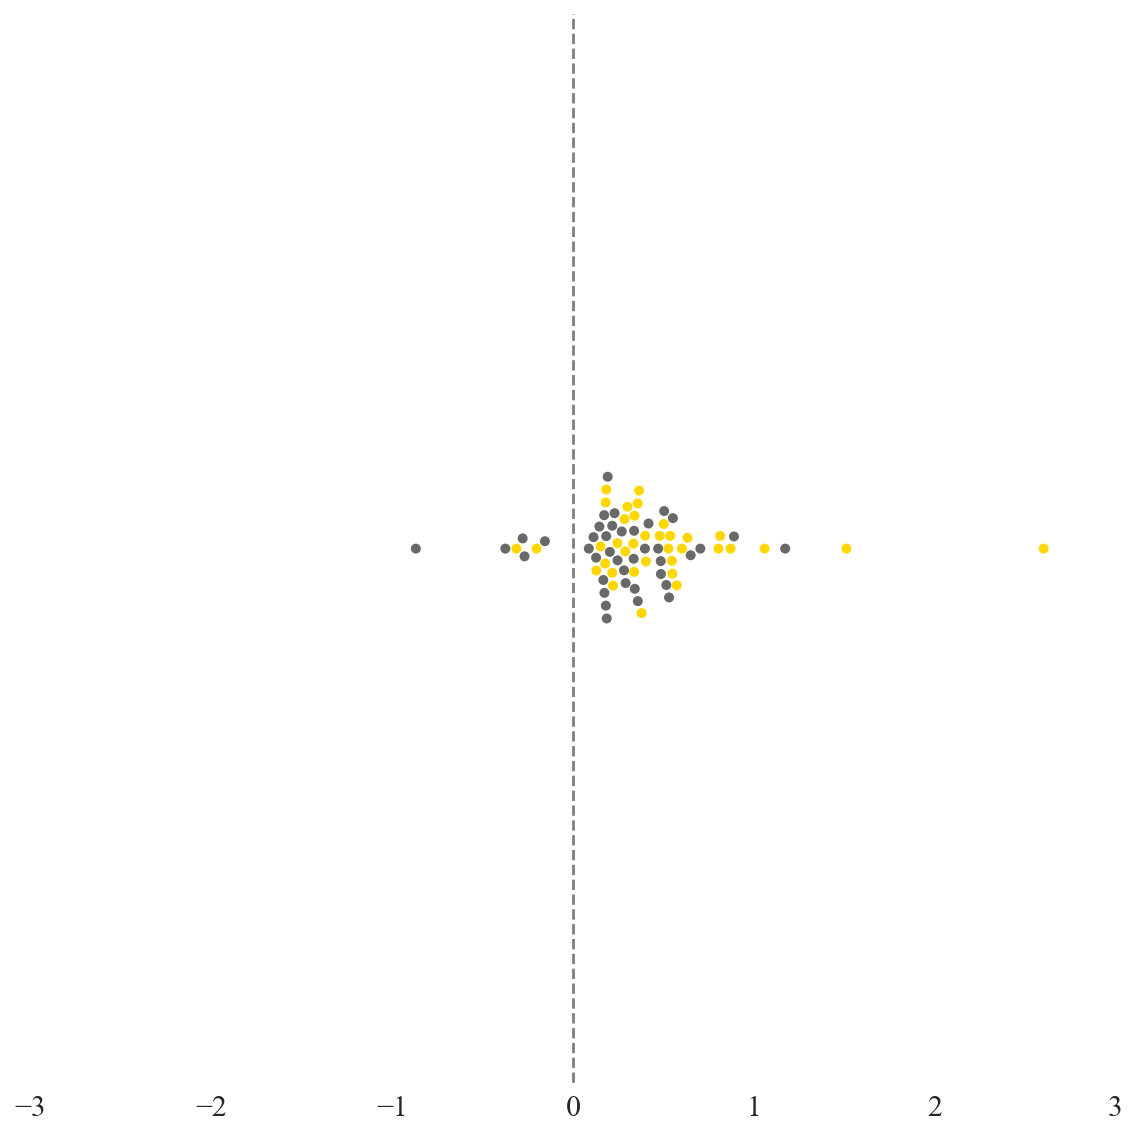

In [75]:
for name in names:
    print(name)

    set_style()
    fig, ax = plt.subplots(1, sharex=False, sharey=False, figsize=(8,8))
    ax = fig.get_axes()[0]

    df = risks.query('drug_map_soc==@name')
    sns.swarmplot(x='logROR_avg', y='drug_map_soc', hue='drug_class', dodge=False, data=df, ax=ax, hue_order=[4,5])

    sns.despine(left=True, bottom=True)
    ax.vlines(0, -10, 10, 'k','dashed', alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim((-3,3))
    ax.yaxis.set_visible(False)
    ax.tick_params(labelsize=15)
    ax.legend([])
    plt.tight_layout()
    plt.show()